## Calculating graph based on mutual information between frequency bands

the implementation is roughly based on teqniques explained here:

https://medium.com/latinxinai/computing-mutual-information-matrix-with-python-6ced9169bcb1

and here:

https://stats.stackexchange.com/questions/179674/number-of-bins-when-computing-mutual-information/181195#181195 



and more deeply here:
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0195941


In [9]:
import os
import time
import pickle
import networkx as nx
import matplotlib.pyplot as plt

import numpy as np
from numpy import linalg as LA
from numpy import histogram2d

from scipy import signal
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import find_peaks, butter, filtfilt
from scipy.ndimage import gaussian_filter
from scipy.io import wavfile

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# read pickle file

with open("../data/processed_data/slices.pkl", "rb") as f:
    data_slices, slice_annotations = pickle.load(f)

# choose 5 random positive and 5 random negative samples
pos_ixs = np.where(slice_annotations == 1)[0]
neg_ixs = np.where(slice_annotations == 0)[0]
rand_pos_ixs = np.random.choice(pos_ixs, size=5, replace=False)
rand_neg_ixs = np.random.choice(neg_ixs, size=5, replace=False)
rand_ixs = np.concatenate([rand_pos_ixs, rand_neg_ixs])
rand_slices = data_slices[rand_ixs]
rand_annotations = slice_annotations[rand_ixs]

In [16]:
for_show = []

fs = 128000
nfft = 16384
hop = 0.25
window = 'hann'
crop_freq = 2000  # Set to None if no cropping is needed
cutoff_freq = None  # 10  # Hz

slice = rand_slices[0]
annotation = rand_annotations[0]

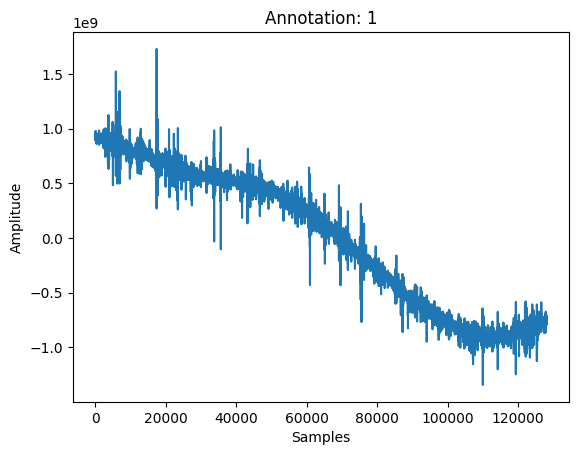

In [17]:
plt.plot(slice)
plt.title(f"Annotation: {annotation}")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

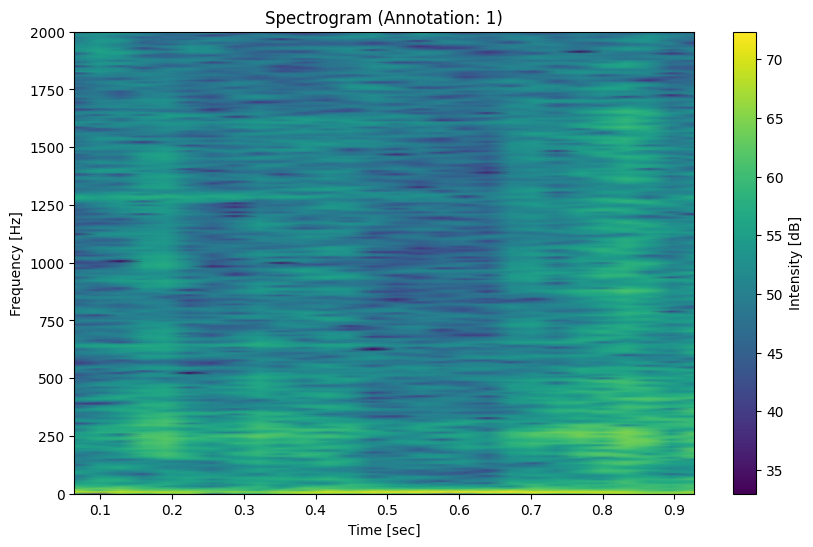

In [18]:
# compute spectrogram
f, t, Sxx = signal.spectrogram(slice, fs=fs, window=window, nperseg=nfft, noverlap = int(nfft * (1 - hop)), mode='magnitude')
Sxx = 10 * np.log10(Sxx + 1e-10)  # Convert to dB scale

# Crop frequencies if specified
if crop_freq is not None:
    freq_mask = f <= crop_freq
    f = f[freq_mask]
    Sxx = Sxx[freq_mask, :]

# high-pass filter
if cutoff_freq is not None:
    b, a = butter(4, cutoff_freq / (0.5 * fs), btype='high')
    Sxx = filtfilt(b, a, Sxx, axis=0)

# plot spectrogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, Sxx, shading='gouraud', cmap='viridis')
plt.colorbar(label='Intensity [dB]')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title(f'Spectrogram (Annotation: {annotation})')
plt.ylim(0, crop_freq if crop_freq is not None else fs / 2)
plt.show()


In [19]:
def joint_entropies(data, nbins=None):
    n_variables = data.shape[-1]
    n_samples = data.shape[0]
    if nbins == None:
        nbins = int((n_samples/5)**.5)
    histograms2d = np.zeros((n_variables, n_variables, nbins, nbins))
    for i in range(n_variables):
        for j in range(n_variables):
            histograms2d[i,j] = np.histogram2d(data[:,i], data[:,j], bins=nbins)[0]
    probs = histograms2d / len(data) + 1e-100
    joint_entropies = -(probs * np.log2(probs)).sum((2,3))
    return joint_entropies

def mutual_info_matrix(data, nbins=None, normalized=True):
    n_variables = data.shape[-1]
    j_entropies = joint_entropies(data, nbins)
    entropies = j_entropies.diagonal()
    entropies_tile = np.tile(entropies, (n_variables, 1))
    sum_entropies = entropies_tile + entropies_tile.T
    mi_matrix = sum_entropies - j_entropies
    if normalized:
        mi_matrix = mi_matrix * 2 / sum_entropies    
    return mi_matrix

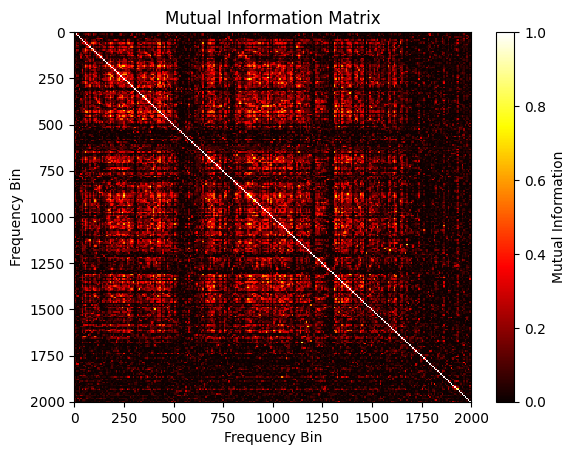

In [20]:
mi = mutual_info_matrix(Sxx.T, normalized=True)

plt.imshow(mi, cmap='hot', interpolation='nearest', extent=[f[0], f[-1], f[-1], f[0]], aspect='auto')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Mutual Information')
plt.title('Mutual Information Matrix')
plt.xlabel('Frequency Bin')
plt.ylabel('Frequency Bin')
plt.show()

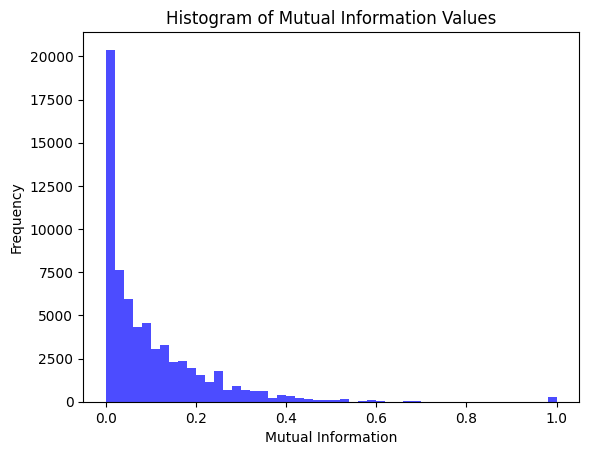

In [21]:
# plot histogram of mi values
plt.hist(mi.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Mutual Information Values')
plt.xlabel('Mutual Information')
plt.ylabel('Frequency')
plt.show()

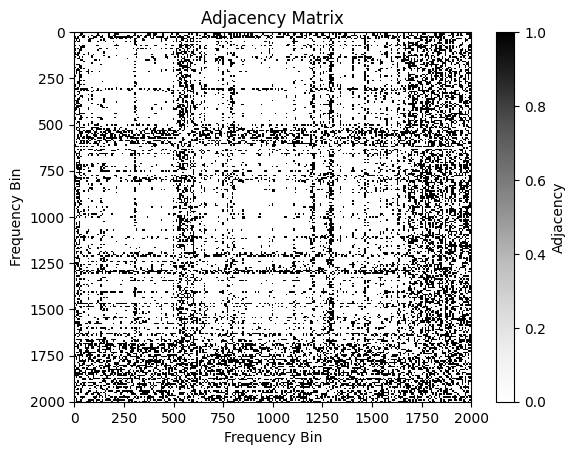

In [26]:
# compute adjacency matrix
threshold = np.percentile(mi, 25)
adj_matrix = (mi <= threshold).astype(int)
np.fill_diagonal(adj_matrix, 0)  # remove self-loops

# plot adjacency matrix
plt.imshow(adj_matrix, cmap='Greys', interpolation='nearest', extent=[f[0], f[-1], f[-1], f[0]], aspect='auto')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Adjacency')
plt.title('Adjacency Matrix')
plt.xlabel('Frequency Bin')
plt.ylabel('Frequency Bin')
plt.show()

In [28]:
#compute the Degree matrix
D = np.diag(np.sum(adj_matrix, axis=1))

# compute Laplacian matrix
L = D - adj_matrix

# compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(L)

# count connected components
eigenvalue_counts = np.sum(np.isclose(eigenvalues, 0, atol=1e-5))

print(f"Number of connected components: {eigenvalue_counts}")


Number of connected components: 1
